# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#https://docs.python.org/3/
import math
import random
import pickle
import collections
import time

#https://python-pillow.org/
from PIL import Image

#https://www.tensorflow.org/
import tensorflow as tf
from tensorflow.contrib.layers import flatten

#http://docs.opencv.org/3.0-beta/index.html
import cv2

#http://www.numpy.org/
import numpy as np

#http://matplotlib.org/
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#http://scikit-learn.org/stable/
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#https://pypi.python.org/pypi/tqdm
from tqdm import tqdm

In [2]:
training_file = 'train.p'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
X_train, y_train = train['features'], train['labels']

testing_file = 'test.p'
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
X_test, y_test = test['features'], test['labels']

In [3]:
n_train = len(X_train)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Training Set Visualization:

  0%|          | 0/100 [00:00<?, ?it/s]

Sample Training Images:


100%|██████████| 100/100 [00:25<00:00,  2.14it/s]


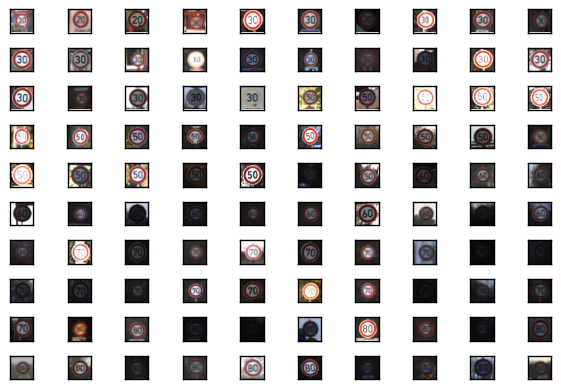

In [4]:
def addsubplot(i, feature):
    plt.subplot(10,10,i)
    plt.xticks(()); plt.yticks(());
    plt.tight_layout()
    plt.imshow(feature)

print('Sample Training Images:')
n = 0
for feature in tqdm(range(0,100)):
    feature = X_train[n*100]
    plt.figure(1)
    addsubplot(n+1, feature)
    n += 1

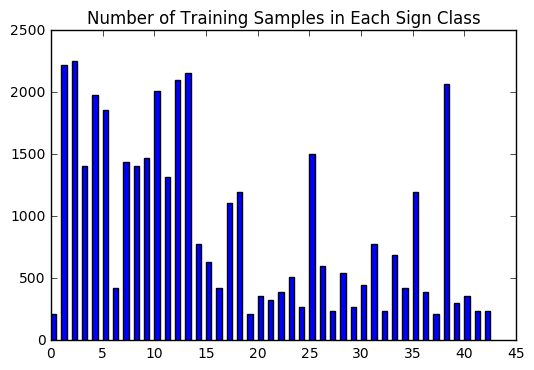

In [5]:
counter = collections.Counter(y_train)
plt.title('Number of Training Samples in Each Sign Class')
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.show()

### Testing Set Visualization:

  2%|▏         | 2/100 [00:00<00:06, 15.09it/s]

Sample Testing Images:


100%|██████████| 100/100 [00:26<00:00,  2.50it/s]


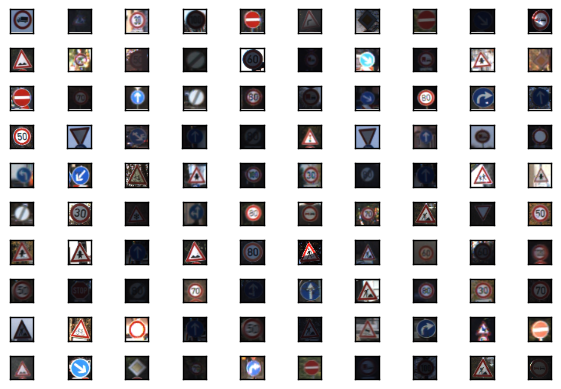

In [6]:
print('Sample Testing Images:')
n = 0
for feature in tqdm(range(0,100)):
    feature = X_test[n*50]
    plt.figure(1)
    addsubplot(n+1, feature)
    n += 1

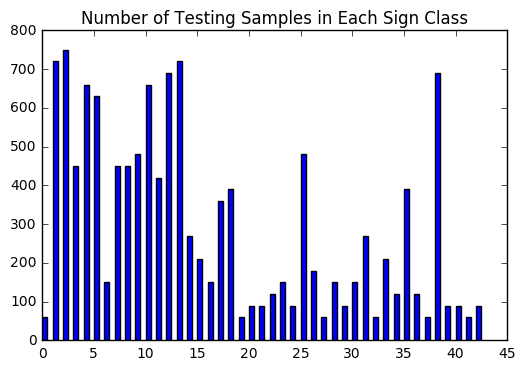

In [7]:
counter = collections.Counter(y_test)
plt.title('Number of Testing Samples in Each Sign Class')
labels, values = zip(*counter.items())

indexes = np.arange(len(labels))
width = 0.5
plt.bar(indexes, values, width)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Pre-processing Training and Testing Features:

In [8]:
def grayscale(image_data):
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY)

def normalize(image_data):
    return image_data / float(255)

def flatten(image_data):
    return image_data.reshape(-1, np.prod(image_data[0].shape))

X_train = flatten(normalize(X_train)).astype(np.float32)
print('Training features pre-processed.')
X_test = flatten(normalize(X_test)).astype(np.float32)
print('Testing features pre-processed.')

Training features pre-processed.
Testing features pre-processed.


### Pre-processing Training and Testing Labels:

In [9]:
def one_hot_encode(label_data):
    encoder = LabelBinarizer()
    encoder.fit(label_data)
    return encoder.transform(label_data)

y_train = one_hot_encode(y_train).astype(np.float32)
print('Training labels pre-processed.')
y_test = one_hot_encode(y_test).astype(np.float32)
print('Testing labels pre-processed.')

Training labels pre-processed.
Testing labels pre-processed.


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

For this step I made the images grayscale, scaled the values to be between 0 and 1 and flatten the images array.

For the `grayscale` method, I'm using `cv2.cvtColor` which we used in the lane detection project to convert a color image to grayscale.

For the `normalize` method, I'm simply dividing each value by 255.

In `flatten` I convert the array from `(32, 32, 1)` to just a 1-D array with `1024` indices.

In [10]:
print('Training Features to randomize and split: ', len(X_train))

def randomize(features, labels):
    return shuffle(features,
                   labels,
                   random_state=42)

X_train, y_train = randomize(X_train, y_train)
print('Training set randomized.')

print('Training Features: ', len(X_train))
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.1,
    random_state=0)
print('Training and validation sets split.')
print('Training Features: ', len(X_train))
print('Validation Features: ', len(X_valid))

Training Features to randomize and split:  39209
Training set randomized.
Training Features:  39209
Training and validation sets split.
Training Features:  35288
Validation Features:  3921


### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [11]:
#Helper methods

def neural_network(features, n_features, n_labels):
    
    layer_widths = {
        'h1_width': 128  
    }

    weights = {
        'h1': tf.Variable(tf.truncated_normal((n_features, layer_widths['h1_width']), stddev=0.01)),
        'out': tf.Variable(tf.truncated_normal((layer_widths['h1_width'], n_labels), stddev=0.01))}

    biases = {
        'h1': tf.Variable(tf.zeros((layer_widths['h1_width'],))),
        'out': tf.Variable(tf.zeros((n_labels,)), name='b_out')}


    h1 = tf.add(tf.matmul(features, weights['h1']), biases['h1'])
    h1 = tf.nn.relu(h1)

    return tf.add(tf.matmul(h1, weights['out']), biases['out'])

def setup_network():
    n_features = np.prod(X_train[0].shape)
    n_labels = n_classes
    counts = (n_features, n_labels)

    features = tf.placeholder(tf.float32)
    labels = tf.placeholder(tf.float32)

    train_feed_dict = {features: X_train, labels: y_train}
    valid_feed_dict = {features: X_valid, labels: y_valid}
    test_feed_dict = {features: X_test, labels: y_test}
    feed_dicts = (train_feed_dict, valid_feed_dict, test_feed_dict)
    
    return (features, labels, counts, feed_dicts)

def plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch):
    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss')
    loss_plot.plot(batches, loss_batch, 'g')
    loss_plot.set_xlim([batches[0], batches[-1]])
    acc_plot = plt.subplot(212)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
    acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
    acc_plot.set_ylim([0, 1.0])
    acc_plot.set_xlim([batches[0], batches[-1]])
    acc_plot.legend(loc=4)
    plt.tight_layout()
    plt.show() 

In [12]:
#Network setup and variable declarations:
features, labels, counts, feed_dicts = setup_network()
n_features, n_labels = counts
train_feed_dict, valid_feed_dict, test_feed_dict = feed_dicts

#Link the German Traffic Signs features and labels to the network architecture:
logits = neural_network(features, n_features, n_labels)

#Loss calculation:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels))

#Accuracy calculation:
is_correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

#Set up the optimizer:
optimizer = tf.train.AdamOptimizer().minimize(loss)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Epoch: 5.000000/30.000000 | Accuracy: 89.36% | Time Elapsed: 225.511818
Epoch: 10.000000/30.000000 | Accuracy: 92.96% | Time Elapsed: 446.779254
Epoch: 15.000000/30.000000 | Accuracy: 93.80% | Time Elapsed: 682.262572
Epoch: 20.000000/30.000000 | Accuracy: 94.44% | Time Elapsed: 903.622072
Epoch: 25.000000/30.000000 | Accuracy: 94.59% | Time Elapsed: 1125.043063
Epoch: 30.000000/30.000000 | Accuracy: 94.75% | Time Elapsed: 1358.516519
Model saved in file: model.ckpt
Training Accuracy: 96.65
Validation Accuracy: 0.95
Test Accuracy: 0.85


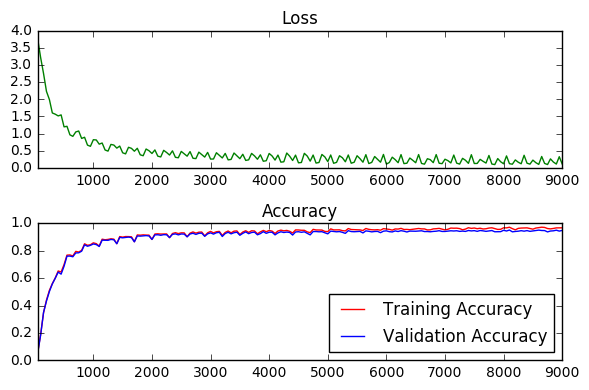

Total Time Elapsed: 1361.47 seconds


In [13]:
#Training parameters:
epochs = 30
batch_size = 128

saver = tf.train.Saver()
start = time.clock()

#Empty arrays to collect and plot loss and accuracy batch data from Training Cycle:
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    
    #Initialize all variables to use them in TensorFlow:
    session.run(tf.initialize_all_variables())
    
    #Calculate the total number of batches needed:
    batch_count = int(math.ceil(len(X_train)/batch_size))

    for epoch_i in range(epochs):
        #Set up and run the training cycle:
        for batch_i in range(batch_count):
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = X_train[batch_start:batch_start + batch_size]
            batch_labels = y_train[batch_start:batch_start + batch_size]

            #Run optimizer in TensorFlow session to get loss value.
            _, l = session.run([optimizer, loss],
                               feed_dict={features: batch_features, labels: batch_labels})
        
        #Store every 50th batch's data in an array to use for visualization:
            if not batch_i % 50:
                #Calculate accuracy of the training and validation sets:
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                #Create arrays for plotting loss and accuracy graphs:
                previous_batch = batches[-1] if batches else 0
                batches.append(50 + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)
        
        if epoch_i % 5 == 4:
            print('Epoch: {:>2f}/{:>2f} | Accuracy: {:^.2f}% | Time Elapsed: {:^2f}'.format(epoch_i+1, epochs, validation_accuracy * 100, (time.clock() - start)))
    
    test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)
    
    # Save checkoint
    save_path = saver.save(session, "model.ckpt")
    print("Model saved in file: {}".format(save_path))
    
print('Training Accuracy: {:^.2f}'.format(training_accuracy * 100))
print('Validation Accuracy: {:^.2f}'.format(validation_accuracy))
print('Test Accuracy: {:^.2f}'.format(test_accuracy))

plot_loss_accuracy(batches, loss_batch, train_acc_batch, valid_acc_batch)

end = time.clock()
print('Total Time Elapsed: {:>.2f} seconds'.format(end - start))

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

Candidate Images:


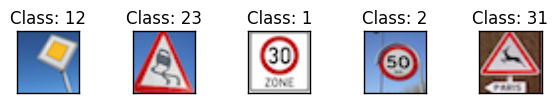

In [15]:
filenames = ['priority_road',
             'slippery_road',
             'limit_30',
             'limit_50',
             'wild_animals']
classes = [12,
           23,
           1,
           2,
           31]

images = []
for sign in filenames:
    images.append(mpimg.imread('signs/' + sign + '.jpg'))

def addsubplot(i, feature):
    plt.subplot(1,5,i)
    plt.xticks(()); plt.yticks(());
    plt.tight_layout(pad=2.5, w_pad=3.0, h_pad=1.0)
    plt.title('Class: {}'.format(classes[i-1]))
    plt.imshow(feature)

print('Candidate Images:')
n = 0
for feature in images:
    plt.figure(1)
    addsubplot(n+1, feature)
    n +=1

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [16]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from scipy.misc import imread
import numpy as np
import csv

def load_image(filename, path="signs/"):
    image = imread("{}{}".format(path, filename))
    image = image.astype(np.float32)
    image = normalize(grayscale(image))
    image = image.reshape(np.prod(image.shape))
    
    return np.array(image)

def load_images(filenames):
    new_images = []
    
    for filename in filenames:
        new_images.append(load_image(filename))
        
    return np.array(new_images)

label_names = {}

with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for (label, name) in reader:
        label_names[label] = name
        

def label_text(label):
    label = str(label)
    return label_names[label]

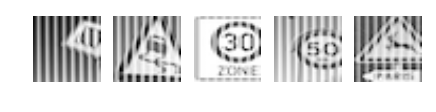

Model restored.


InvalidArgumentError: Matrix size-compatible: In[0]: [5,1024], In[1]: [3072,128]
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_0, Variable/read)]]

Caused by op 'MatMul', defined at:
  File "//anaconda/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "//anaconda/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "//anaconda/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "//anaconda/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "//anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "//anaconda/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "//anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-d38d10575250>", line 7, in <module>
    logits = neural_network(features, n_features, n_labels)
  File "<ipython-input-11-c31b48813d6b>", line 18, in neural_network
    h1 = tf.add(tf.matmul(features, weights['h1']), biases['h1'])
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 1398, in matmul
    name=name)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 1348, in _mat_mul
    transpose_b=transpose_b, name=name)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "//anaconda/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Matrix size-compatible: In[0]: [5,1024], In[1]: [3072,128]
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_Placeholder_0, Variable/read)]]


In [17]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

filenames = [
    'priority_road.jpg',
    'slippery_road.jpg',
    'limit_30.jpg',
    'limit_50.jpg',
    'wild_animals.jpg']

images = load_images(filenames)

saver = tf.train.Saver()

f = plt.figure(figsize=(5, 1))

for i, image in enumerate(images):
    image = image.reshape(32, 32)
    ax = f.add_subplot(1, 5, (i + 1))
    ax.axis('off')
    ax.imshow(image, cmap='gray')

plt.show()

with tf.Session() as session:
    saver.restore(session, "model.ckpt")
    print("Model restored.")
    
    prediction_op = tf.argmax(logits, 1)
    predictions = session.run(prediction_op, feed_dict={features: images})
    
    print("{:30}{:8}{:20}".format("filename", "label", "prediction"))
    for idx, prediction in enumerate(predictions):
        print("{:30}{:<8}{:20}".format(filenames[idx], prediction, label_text(prediction)))

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import matplotlib.pyplot as plt

# Original version of this plotting function is from a response on the CarND forums.
def plot_top_k_probabilities(labels, probabilities, title):
    print(title)
    plt.plot(list(labels), list(probabilities), 'ro')
    plt.ylabel('Probability') 
    plt.show()

filenames = [
    'priority_road.jpg',
    'slippery_road.jpg',
    'limit_30.jpg',
    'limit_50.jpg',
    'wild_animals.jpg']

filename_labels = [12,
                   23,
                   1,
                   2,
                   31]

encoder = LabelBinarizer()
encoder.fit(y_train)
encoded_labels = encoder.transform(filename_labels)

images = load_images(filenames)

saver = tf.train.Saver()

with tf.Session() as session:
    saver.restore(session, "./model.ckpt")
    print("Model restored.")
    
    prediction_op = tf.nn.softmax(logits)
    top_five = tf.nn.top_k(prediction_op, k=5, sorted=True, name=None)
    predictions, acc = session.run([top_five, accuracy], feed_dict={features: images, labels: encoded_labels})
    prediction_values, prediction_indices = predictions
    
    print('Validation accuracy at {}'.format(validation_accuracy))
    print('Test accuracy at {}'.format(test_accuracy))
    print('5 image test accuracy at {}'.format(acc))
    
    for idx, (probabilities, labels) in enumerate(zip(prediction_values, prediction_indices)):
        title = "Predicted ({}) {}, Actual ({}) {}".format(labels[0], label_text(labels[0]), filename_labels[idx], filenames[idx])
        plot_top_k_probabilities(labels, probabilities, title)

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

<span style="color: blue"> _**N/A**_ </span>

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.